# **Basic Data Transformations** 

**Course:** Artificial Intelligence and Machine Learning

**Author:** Mario Guillén  

**Objective:** Using basic data transformations to analyze a dataset.

**TL;DR:** We use linear regression to predict California housing prices. After preprocessing and regularization, the best model achieved an RMSE of ~71k (≈30% of average house value). Residual analysis shows systematic bias, suggesting non-linearities. While performance is limited, the exercise highlights feature importance and sets the stage for more advanced models.

**Dataset:** [California Housing Prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices)

## Table of Contents
1. Introduction & Objectives
2. Data Loading & Audit
3. Preprocessing & Feature Engineering
4. Modeling & Validation
5. Evaluation & Error Analysis
6. Conclusions & Next Steps

## 1. Introduction & Objectives

This notebook demonstrates how fundamental data transformations can improve the performance of predictive models. We focus on the **California Housing Prices** dataset, a widely used benchmark for regression tasks.

The main objectives are:
- Apply transformations such as **Min–Max Scaling** and **Power Transformation** to handle differences in scale and reduce skewness.  
- Prepare the dataset for use with **Linear Regression**, a model that is sensitive to feature scaling and distributional assumptions.  
- Evaluate how these transformations affect model accuracy and error distribution.  

By the end, we will obtain a linear regression model capable of predicting housing prices based on key features, while gaining insights into the importance of preprocessing in machine learning pipelines.

## 2. Data Loading & Audit

In this step we load the data and perform an initial audit of the data to understand its quality and structure. Specifically we:
- List the columns with missing values and how many there are.
- Detect invalid values in the dataset (e.g., negative values and locations outside of the California area)
- Generate descriptive statistics for numerical features and count potential outliers.
- Use **Pearson's correlation coeficient** to look for features with high indices of collinearity.

These checks guide the preprocessing strategy and provide context for interpreting the model’s results.

### 2.1 Data Loading and Initial Set Up

In [1]:
# We run out initial set up
%run ../_common/00_setup.ipynb

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import power_transform, FunctionTransformer, MinMaxScaler,PowerTransformer,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,KFold,GridSearchCV,cross_val_score, cross_validate
from ai_ml_utils import detect_outliers_iqr, Winsorizer, evaluate_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# Optional: download latest dataset version from Kaggle
# import kagglehub
# path = kagglehub.dataset_download("camnugent/california-housing-prices")
# print("Path to dataset files:", path)

In [4]:
# We load the file onto our environment:
df = pd.read_csv(DATA_DIR / "housing.csv", sep=",")
print(f"Shape: {df.shape}")
print("\nDtypes:\n", df.dtypes)

Shape: (20640, 10)

Dtypes:
 longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object


### 2.2 Missing Data and Duplicates Check

In [5]:
# We check for missing values and duplicates
miss = df.isna().sum().sort_values(ascending=False)
display(miss[miss > 0])
dup_count = df.duplicated().sum()
print(f"Exact-duplicate rows: {dup_count}")

total_bedrooms    207
dtype: int64

Exact-duplicate rows: 0


### 2.3 Invalid Data Check

In [6]:
# We look for columns with negative numbers as this would not make sense in our dataset (outside of the longitude column)
num_cols = df.select_dtypes(include=[np.number]).columns
neg_violations = {c: int((df[c] < 0).sum()) for c in num_cols}
neg_violations = {k:v for k,v in neg_violations.items() if v > 0 and k != 'longitude'}
print("Negative-value counts (possible issues):", neg_violations)

# We look for locations outside california range
lon_in = df["longitude"].between(-125, -113, inclusive="both").mean()
lat_in = df["latitude"].between(32, 43, inclusive="both").mean()
print(f"Longitude within CA bounds: {lon_in:.2%} | Latitude within CA bounds: {lat_in:.2%}")

Negative-value counts (possible issues): {}
Longitude within CA bounds: 100.00% | Latitude within CA bounds: 100.00%


### 2.4 Feature Overview

In [7]:
# Target Column - Used later in prediction model
TARGET = "median_house_value"
assert TARGET in df.columns, "Expected target column not found."

num_cols = df.select_dtypes(include=[np.number]).columns.drop(TARGET, errors="ignore")
cat_cols = df.select_dtypes(exclude=[np.number]).columns

print("Numeric features:", list(num_cols))
print("Categorical features:", list(cat_cols))

# Cardinality for categorical columns
for c in cat_cols:
    print(f"{c}: {df[c].nunique()} unique values")

# Constant features
constant_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
print("Constant features:", constant_cols)

# Summary stats
desc = df[num_cols.union([TARGET]).tolist()].describe().T
desc.index.name = "feature"

Numeric features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
Categorical features: ['ocean_proximity']
ocean_proximity: 5 unique values
Constant features: []


In [8]:
from scipy.stats import skew, kurtosis

# Creation of a dataframe that saves the skewness and kurtosis values in our dataframe
skew_kurt = pd.DataFrame({
    "feature": num_cols,
    "skew": [skew(df[c].dropna()) for c in num_cols],
    "kurtosis": [kurtosis(df[c].dropna()) for c in num_cols]
}).set_index("feature")

# Checking for outliers using the IQR rule of thumb)
iqr_report = []
for c in num_cols.union([TARGET]):
    q1, q3 = df[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    lo = q1 - 1.5 * iqr
    hi = q3 + 1.5 * iqr
    share = ((df[c] < lo) | (df[c] > hi)).mean()
    iqr_report.append({"feature": c, "outlier_share": round(share, 4)})
iqr_df = pd.DataFrame(iqr_report).set_index("feature")

report = (
    desc
    .join(skew_kurt, how="left")
    .join(iqr_df, how="left")
)

display(report)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,outlier_share
feature,,,,,,,,,,,
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000,3.410190,22.052354,0.0591
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000,0.060326,-0.800726,0.0000
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500,0.465919,-1.117780,0.0000
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100,-0.297780,-1.330121,0.0000
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000,NaN,NaN,0.0519
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001,1.646537,4.951034,0.0330
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000,4.935500,73.535009,0.0579
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000,3.459292,21.979902,0.0616
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000,4.147042,32.622732,0.0624


### 2.5 Correlation Checks 

We will use **Pearson’s correlation coefficient** to analyze collinearity among features.  
This metric quantifies the **strength and direction of a linear relationship** between two variables, ranging from **+1 (perfect positive correlation)** to **–1 (perfect negative correlation)**.  

Examining correlations is a crucial step for:  
- Detecting strongly related features (which may introduce redundancy or multicollinearity).  
- Identifying features with meaningful relationships to the target variable.  

**Note:** Pearson’s method assumes that relationships are approximately **linear** and that variables are **normally distributed**. For non-linear relationships, other measures (e.g., Spearman’s rank correlation) may be more appropriate.

In [9]:
corr = df[num_cols.union([TARGET])].corr(method='pearson', min_periods=1)

# We look for features with hifh collinearity
top_corr = corr[TARGET].drop(TARGET).sort_values(ascending=False)
suspicious = top_corr[abs(top_corr) > 0.95]
if len(suspicious):
    print("Potential high collinearity:\n", suspicious)

Saved figure -> reports\figures\correlation_heatmap.png


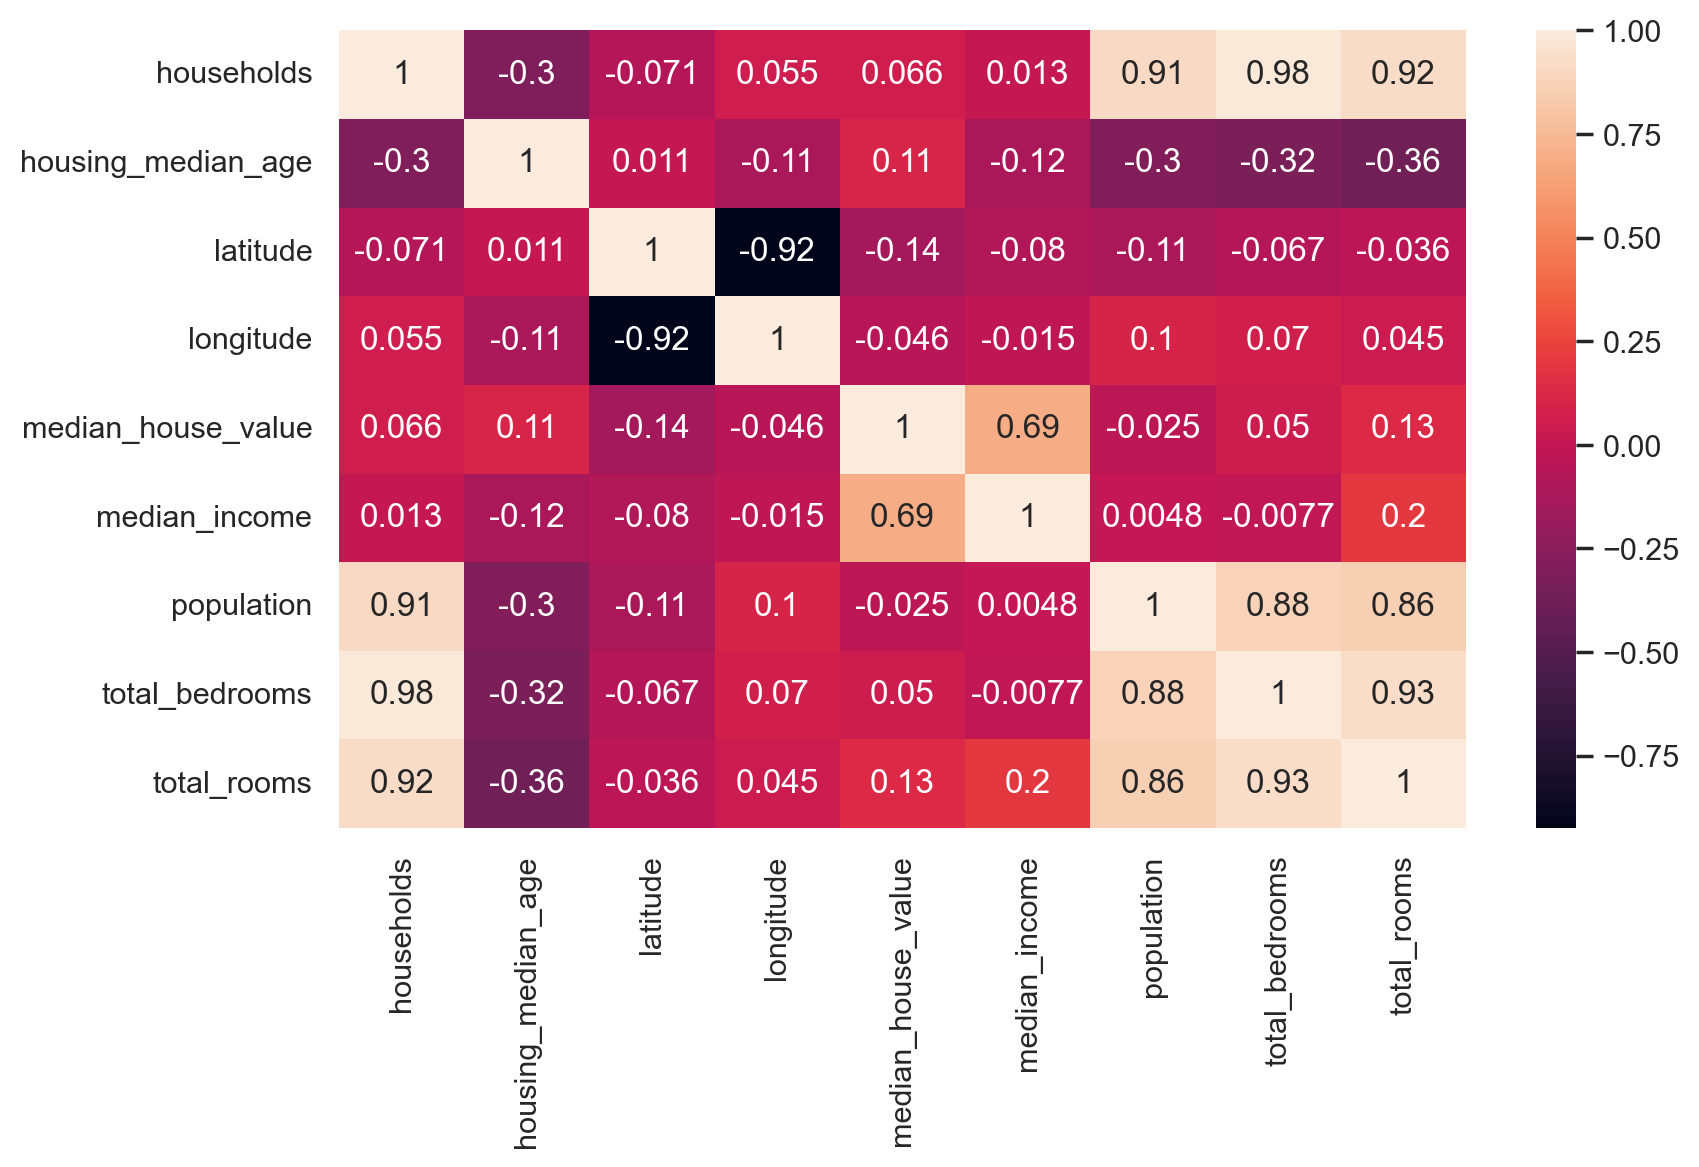

In [10]:
sns.set(rc={'figure.figsize':(9,6)})
sns.heatmap(data = corr,annot = True)
save_fig("correlation_heatmap")
plt.show()

### 2.6 Persisting Results

In [11]:
# Saving audit tables
miss.to_csv(ARTIFACTS / "missing_values.csv", header=["missing_count"])
skew_kurt.to_csv(ARTIFACTS / "skew_kurtosis.csv", index=False)
pd.DataFrame({"top_corr_with_target": top_corr}).to_csv(ARTIFACTS / "top_corr_with_target.csv")

# Saving a compact version
summary_metrics = {
    "missing_values_total": int(miss.sum()),
    "duplicate_rows": int(dup_count),
    "features_with_missing": int((miss > 0).sum())
}
save_metrics(summary_metrics, name="audit_summary.json")

Saved metrics -> reports\artifacts\audit_summary.json


WindowsPath('reports/artifacts/audit_summary.json')

## 3. Preprocessing & Feature Engineering

To simplify model construction and reduce multicollinearity, we restrict the analysis to a subset of key features. Based on the correlation analysis, we exclude latitude and longitude, as well as population, which was highly collinear with several other predictors. This choice streamlines preprocessing while preserving enough information to build a functional and interpretable model.

The selected features are:  
- housing_median_age  
- total_rooms  
- total_bedrooms  
- households  
- median_income   
- ocean_proximity  

Target Column: median_house_value

In addition, we create a derived feature **bedroom ratio**, defined as ``total_bedrooms ÷ total_rooms``, to capture housing density more explicitly.

Next, we analyze the distributions of these variables to determine the appropriate preprocessing steps.

Saved figure -> reports\figures\feature_histograms.png


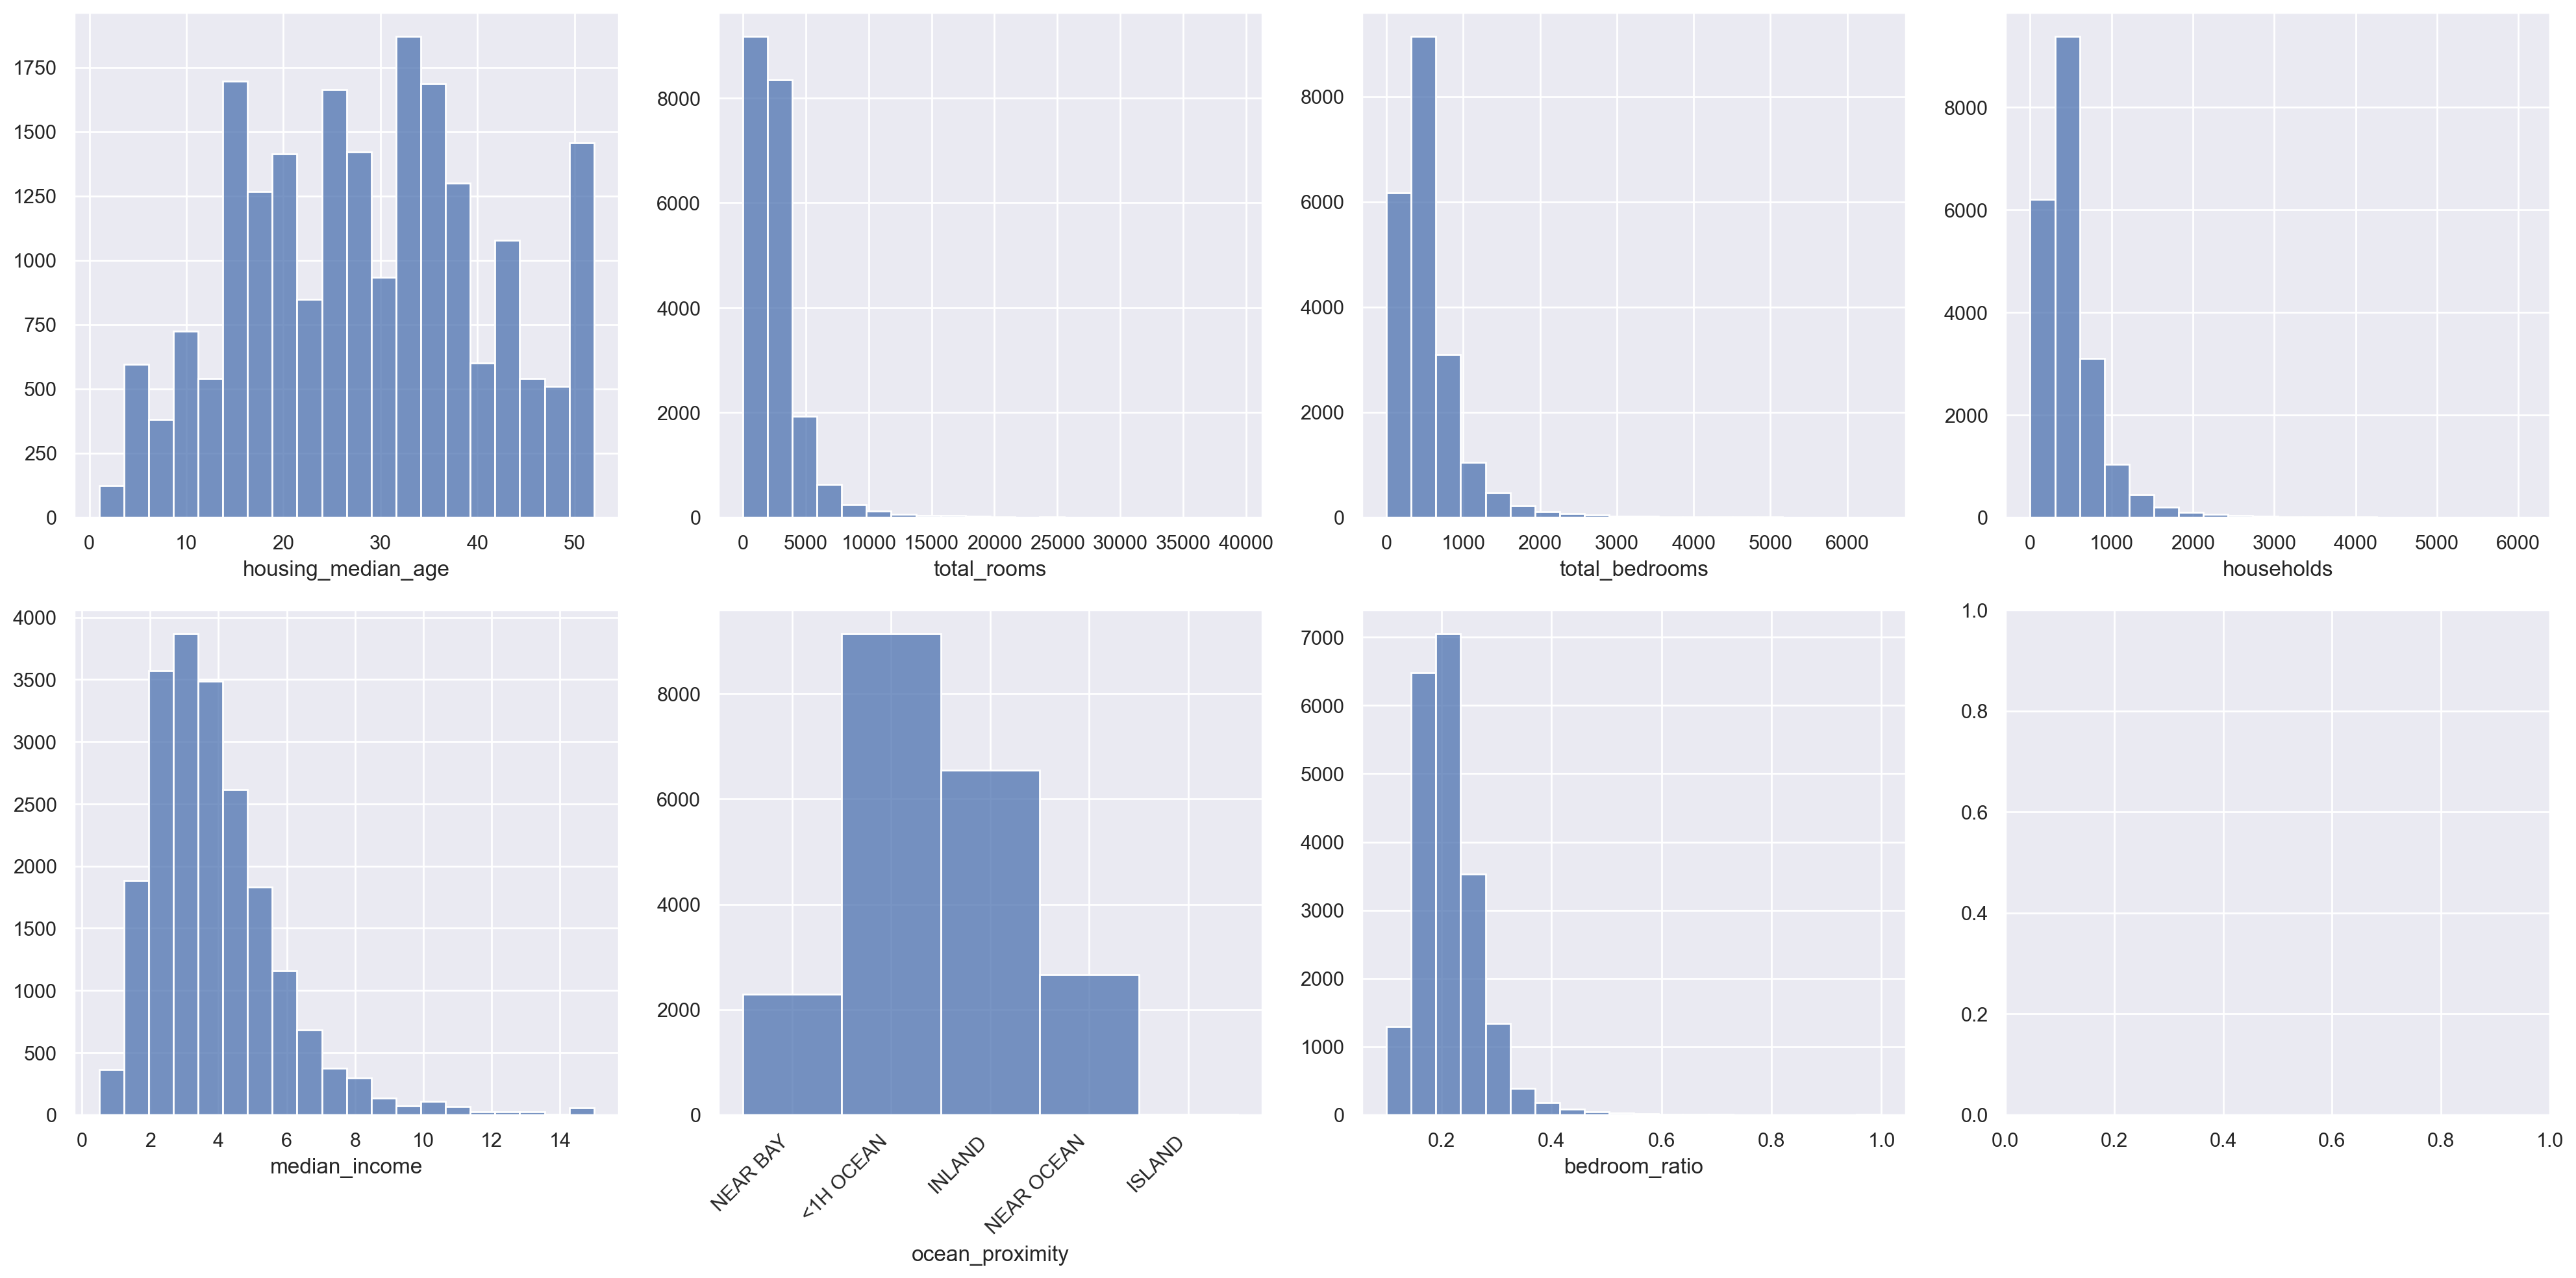

In [12]:
# Creating the new feature
df['bedroom_ratio'] = (df["total_bedrooms"] / df["total_rooms"]).replace([np.inf, -np.inf], np.nan)
# List of the names of the 7 variables we will work with in this exercise.
variables_to_transform = ['housing_median_age','total_rooms','total_bedrooms','households','median_income','ocean_proximity','bedroom_ratio']

sns.set(rc={'figure.figsize':(20,10)})
fig, axes = plt.subplots(2, 4)

for k in range(len(variables_to_transform)):
    
    plt.subplot(2,4,k+1)
    Transf0 = df[variables_to_transform[k]]          
    ax = sns.histplot(data = Transf0, bins = 20)  
    ax.set_ylabel("")
    if variables_to_transform[k] == 'ocean_proximity':
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    else:
        ax.set_xlabel(variables_to_transform[k])

save_fig("feature_histograms")
plt.show()

After analysing the histograms we will be creating the following pipeline:

**Numeric features**
1. **Outlier capping (1st/99th percentiles):** Reduce the influence of extreme values. *(Thresholds learned on the training split, then applied to train/test.)*
2. **Imputation (median):** Handle missing values (e.g., `total_bedrooms`) robustly against skew.
3. **Power transform (Yeo–Johnson):** Reduce skewness and stabilize variance to better meet linear-model assumptions about residuals.
4. **Scaling (Min–Max):** Put features on comparable scales for stable optimization and interpretability.

**Categorical features**
1. **Imputation (most frequent):** Guard against occasional missing categories in future/serving data.
2. **One-Hot Encoding:** Convert categories to numeric indicators *(use `handle_unknown="ignore"` to remain robust to unseen categories)*.

In [13]:
num_features = [
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "households",
    "median_income",
    "bedroom_ratio"
]
cat_features = ["ocean_proximity"]

In [14]:
numeric_pipeline = Pipeline(steps=[
    ("winsor", Winsorizer(columns=num_features, lower_q=0.01, upper_q=0.99)),
    ("imputer", SimpleImputer(strategy="median")),
    ("power", PowerTransformer(method="yeo-johnson", standardize=False)),
    ("scaler", MinMaxScaler()),
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_features),
        ("cat", categorical_pipeline, cat_features),
    ],
    remainder="drop",
)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("linreg", LinearRegression())
])

## 4. Modeling & Validation

In this section we compare several linear regression approaches to understand their performance and limitations. This allows us to select an appropriate model for final evaluation on the test set. The process follows these steps:
- Train–test split: Divide the dataset into 80% training and 20% testing, ensuring a representative hold-out sample for final evaluation.
- Baseline model: Fit a Dummy regressor (mean predictor) to provide a performance benchmark.
- Ordinary Linear Regression: Train a standard linear regression model as a reference.
- Regularized models: Use GridSearchCV to tune and compare Ridge and Lasso regressors across a range of α values, selecting the best configuration via cross-validation.

In [15]:
y = df[TARGET]
X = df[num_features + cat_features ]

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=RANDOM_SEED)


print(f'Training Set    X:{Xtrain.shape} y:{ytrain.shape}')
print(f'Test Set    X:{Xtest.shape}  y:{ytest.shape}')

Training Set    X:(16512, 7) y:(16512,)
Test Set    X:(4128, 7)  y:(4128,)


### 4.1 Baseline

We can now use a dummy regressor model in order to get a baseline score and have a comparison point to our model.

In [16]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [17]:
baseline = Pipeline([
    ("prep", preprocess),
    ("model", DummyRegressor(strategy="mean"))
])
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2"
}
base_cv = cross_validate(baseline, Xtrain, ytrain, cv=cv, scoring=scoring, n_jobs=-1)
print("Baseline — RMSE: %.3f ± %.3f | MAE: %.3f ± %.3f | R2: %.3f ± %.3f" % (
    -base_cv["test_rmse"].mean(), base_cv["test_rmse"].std(),
    -base_cv["test_mae"].mean(), base_cv["test_mae"].std(),
     base_cv["test_r2"].mean(),  base_cv["test_r2"].std()
))

Baseline — RMSE: 115617.185 ± 1216.280 | MAE: 91391.475 ± 1008.243 | R2: -0.000 ± 0.000


### 4.2 Ordinary Linear Regressor

We use cross-validation to get the results for the original linear regressor so that we can later compare it to Ridge, Lasso and the baseline score.

In [18]:
LS =  Pipeline([("prep", preprocess),("model", LinearRegression())])
LSModel = cross_validate(LS, Xtrain, ytrain, cv=cv, scoring=scoring, n_jobs=-1)

In [19]:
print("LS — RMSE: %.3f ± %.3f | MAE: %.3f ± %.3f | R2: %.3f ± %.3f" % (
    -LSModel["test_rmse"].mean(), LSModel["test_rmse"].std(),
    -LSModel["test_mae"].mean(),  LSModel["test_mae"].std(),
     LSModel["test_r2"].mean(),   LSModel["test_r2"].std()
))

LS — RMSE: 74571.313 ± 1191.968 | MAE: 56622.866 ± 597.634 | R2: 0.584 ± 0.010


### 4.3 Hyperparameter tuning (Ridge/Lasso alphas)

In [20]:

pipe = Pipeline([
    ("prep", preprocess),     # Previously created transformer
    ("model", Ridge())        # This is a placeholder model
])

# This will part of our grid 
alphas = np.logspace(-3, 3, 13)  # [0.001, 0.01, ..., 1000]

# This will be our grid for the grid search
param_grid = [
    {"model": [Ridge()], "model__alpha": alphas},                     # grid for Ridge
    {"model": [Lasso(max_iter=5000)], "model__alpha": alphas},        # grid for Lasso
]

# GridSearchCV across both models at once
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # maximize negative RMSE = minimize RMSE
    cv=cv,          
    n_jobs=-1       
)

# Fit on training data
grid.fit(Xtrain, ytrain)

# Results
print("Best model:", type(grid.best_estimator_.named_steps["model"]).__name__)
print("Best params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

Best model: Lasso
Best params: {'model': Lasso(max_iter=5000), 'model__alpha': 1.0}
Best CV RMSE: 74570.65316878047


In [21]:
res = pd.DataFrame(grid.cv_results_)
res["alpha"] = res["param_model__alpha"].astype(float)
res["model"] = res["param_model"].astype(str).str.extract(r"([A-Za-z]+)\(")
res["rmse"] = -res["mean_test_score"]
display(res.sort_values("rmse").head(10)[["model","alpha","rmse"]])

,model,alpha,rmse
19,Lasso,1.000000,74570.653169
3,Ridge,0.031623,74570.952063
20,Lasso,3.162278,74570.959987
18,Lasso,0.316228,74571.049396
2,Ridge,0.010000,74571.123307
17,Lasso,0.100000,74571.224029
1,Ridge,0.003162,74571.244975
16,Lasso,0.031623,74571.284178
0,Ridge,0.001000,74571.290547
15,Lasso,0.010000,74571.303691


## 5. Evaluation & Error Analysis

From the previous section we selected the Ridge model, which achieved the lowest cross-validated error and substantially outperformed the baseline. This suggests the model is capturing meaningful variance in the data. In this section, we evaluate its performance on the held-out test set and analyze the results using the following steps:
- Residuals vs predicted plot: to examine where the model makes errors and whether these follow systematic patterns.
- QQ-plot of residuals: to assess whether the residuals approximately follow a normal distribution, as assumed by linear regression.
- Histogram of residuals: to visualize the distribution of prediction errors relative to actual values.
- Feature importance: to identify the most influential predictors and gain insights into what drives the model’s results.

In [22]:
best = grid.best_estimator_
best.fit(Xtrain, ytrain)
ypred = best.predict(Xtest)
print(evaluate_regression(ytest,ypred))

{'rmse': 80724.05067509036, 'mae': 59569.272882612466, 'r2': 0.502722244307104}


In [23]:
test_rmse = mean_squared_error(ytest, ypred) **0.5
test_mae  = mean_absolute_error(ytest, ypred)
test_r2   = r2_score(ytest, ypred)
save_metrics({"rmse": float(test_rmse), "mae": float(test_mae), "r2": float(test_r2)},
             name="metrics_linear.json")

Saved metrics -> reports\artifacts\metrics_linear.json


WindowsPath('reports/artifacts/metrics_linear.json')

In [24]:
# Make sure y_test is a Series/1-D
if isinstance(ytest, pd.DataFrame):
    y_test_1d = ytest.iloc[:, 0].to_numpy().ravel()
else:
    y_test_1d = np.asarray(ytest).ravel()

y_pred_1d = np.asarray(ypred).ravel() 

assert y_test_1d.shape == y_pred_1d.shape, (y_test_1d.shape, y_pred_1d.shape)

Saved figure -> reports\figures\residuals_vs_predicted.png
Saved figure -> reports\figures\qqplot_residuals.png
Saved figure -> reports\figures\residuals_hist.png


WindowsPath('reports/figures/residuals_hist.png')

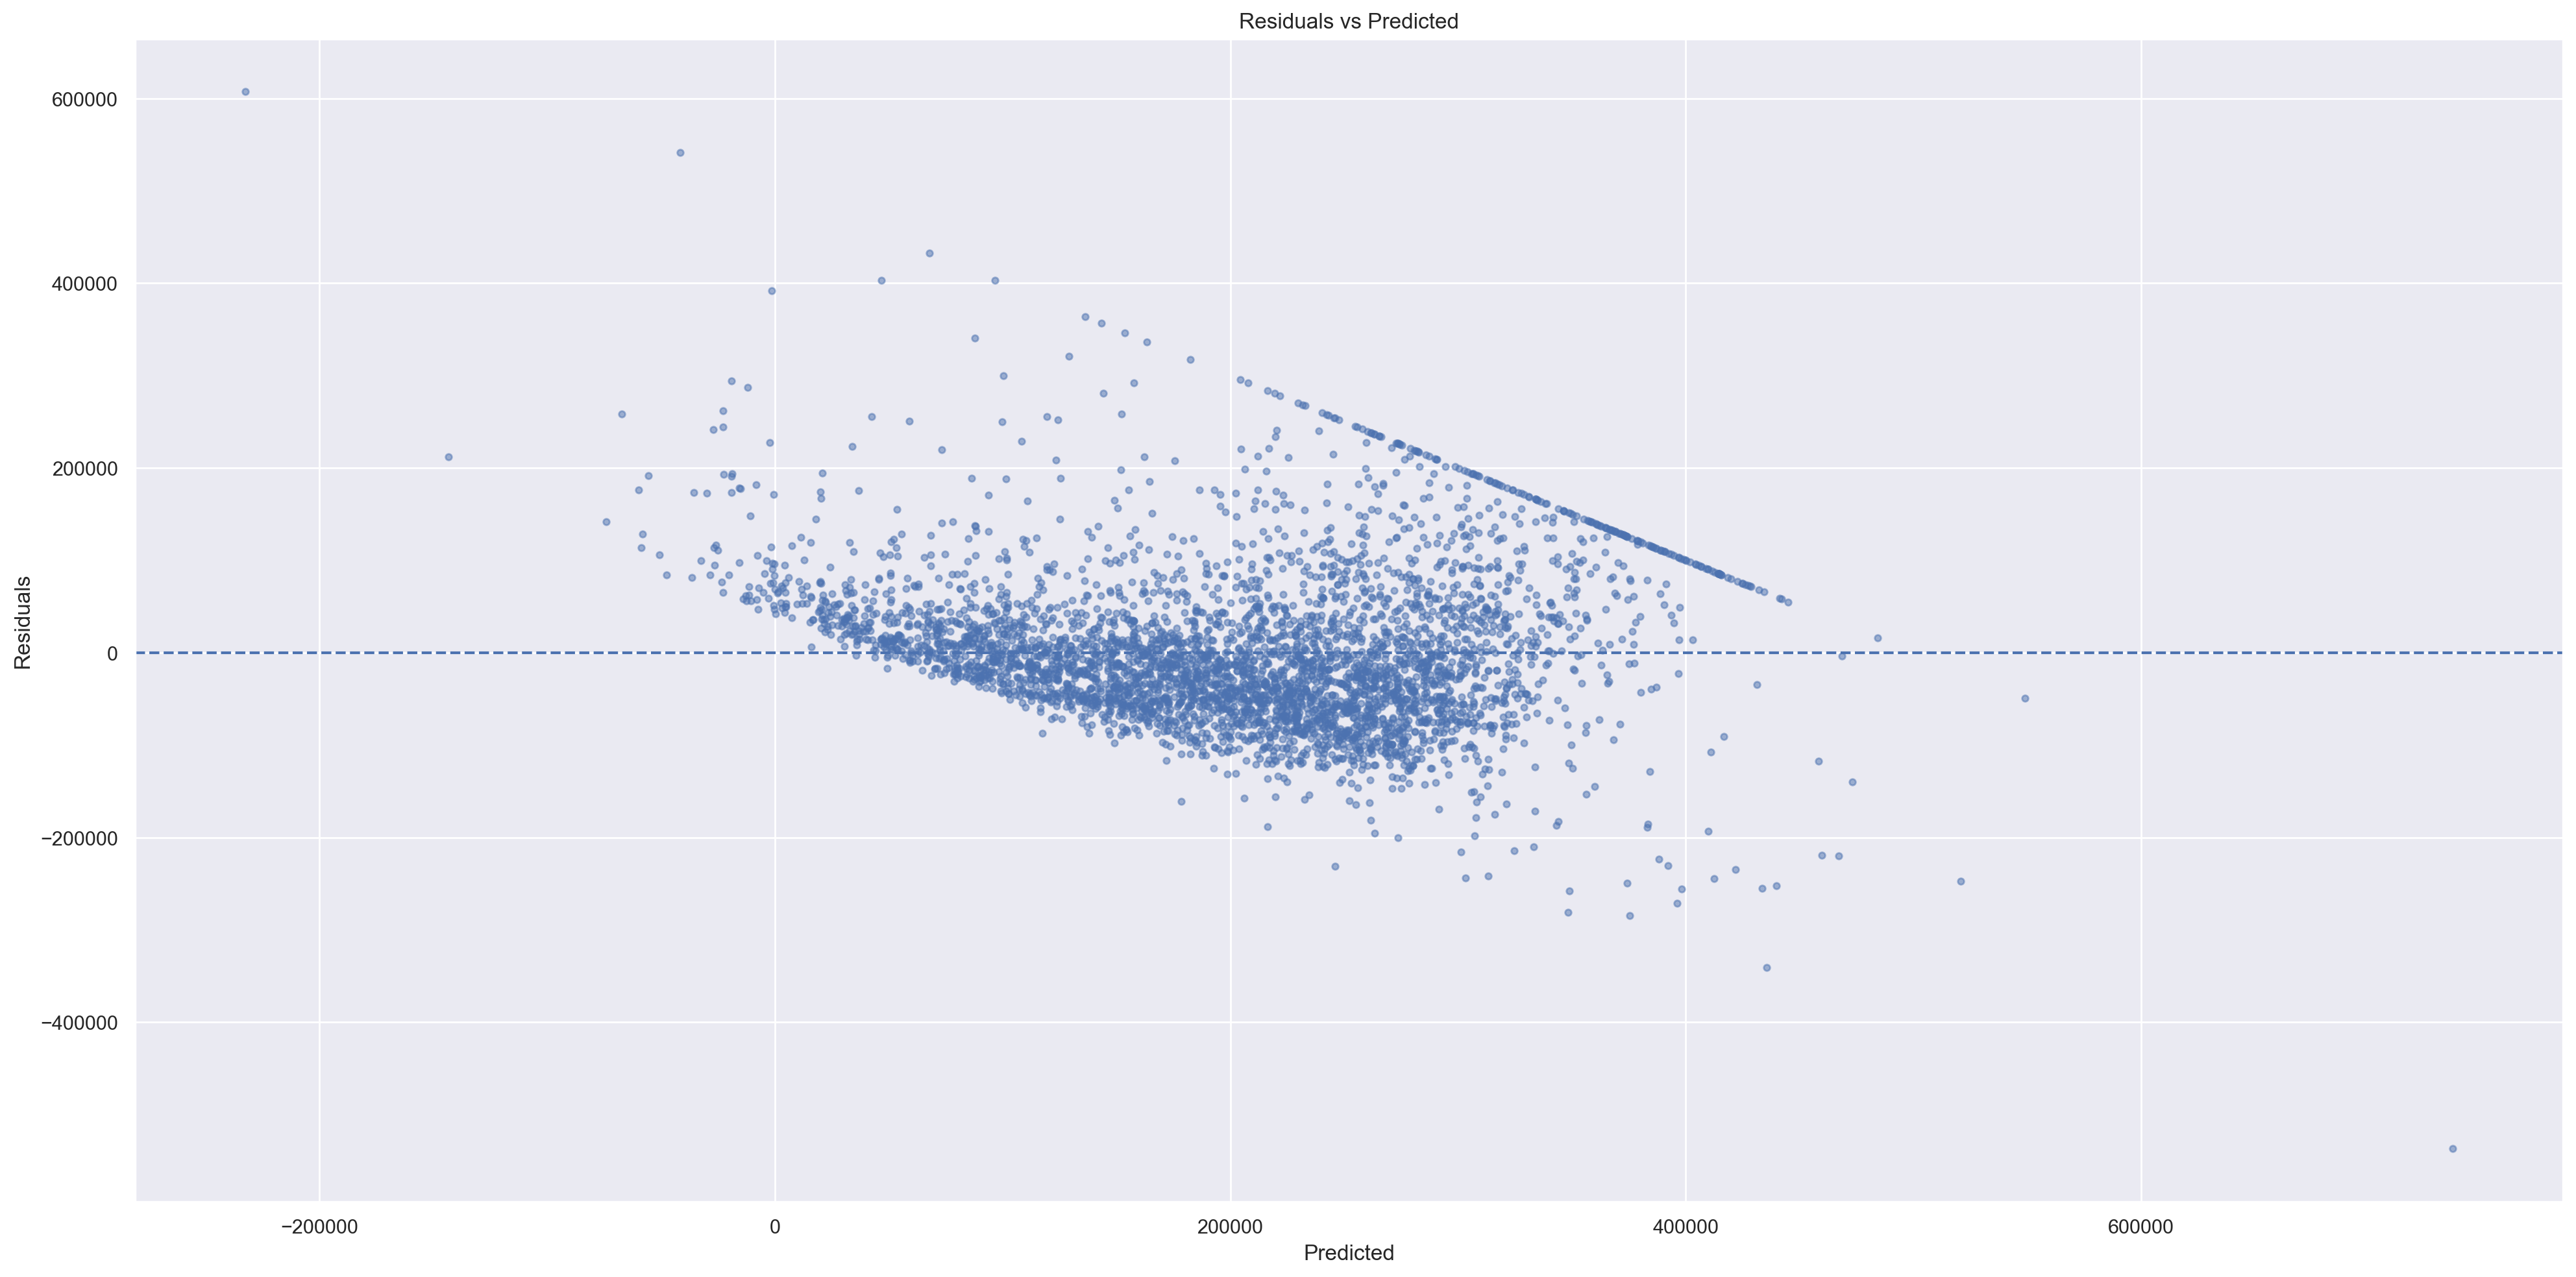

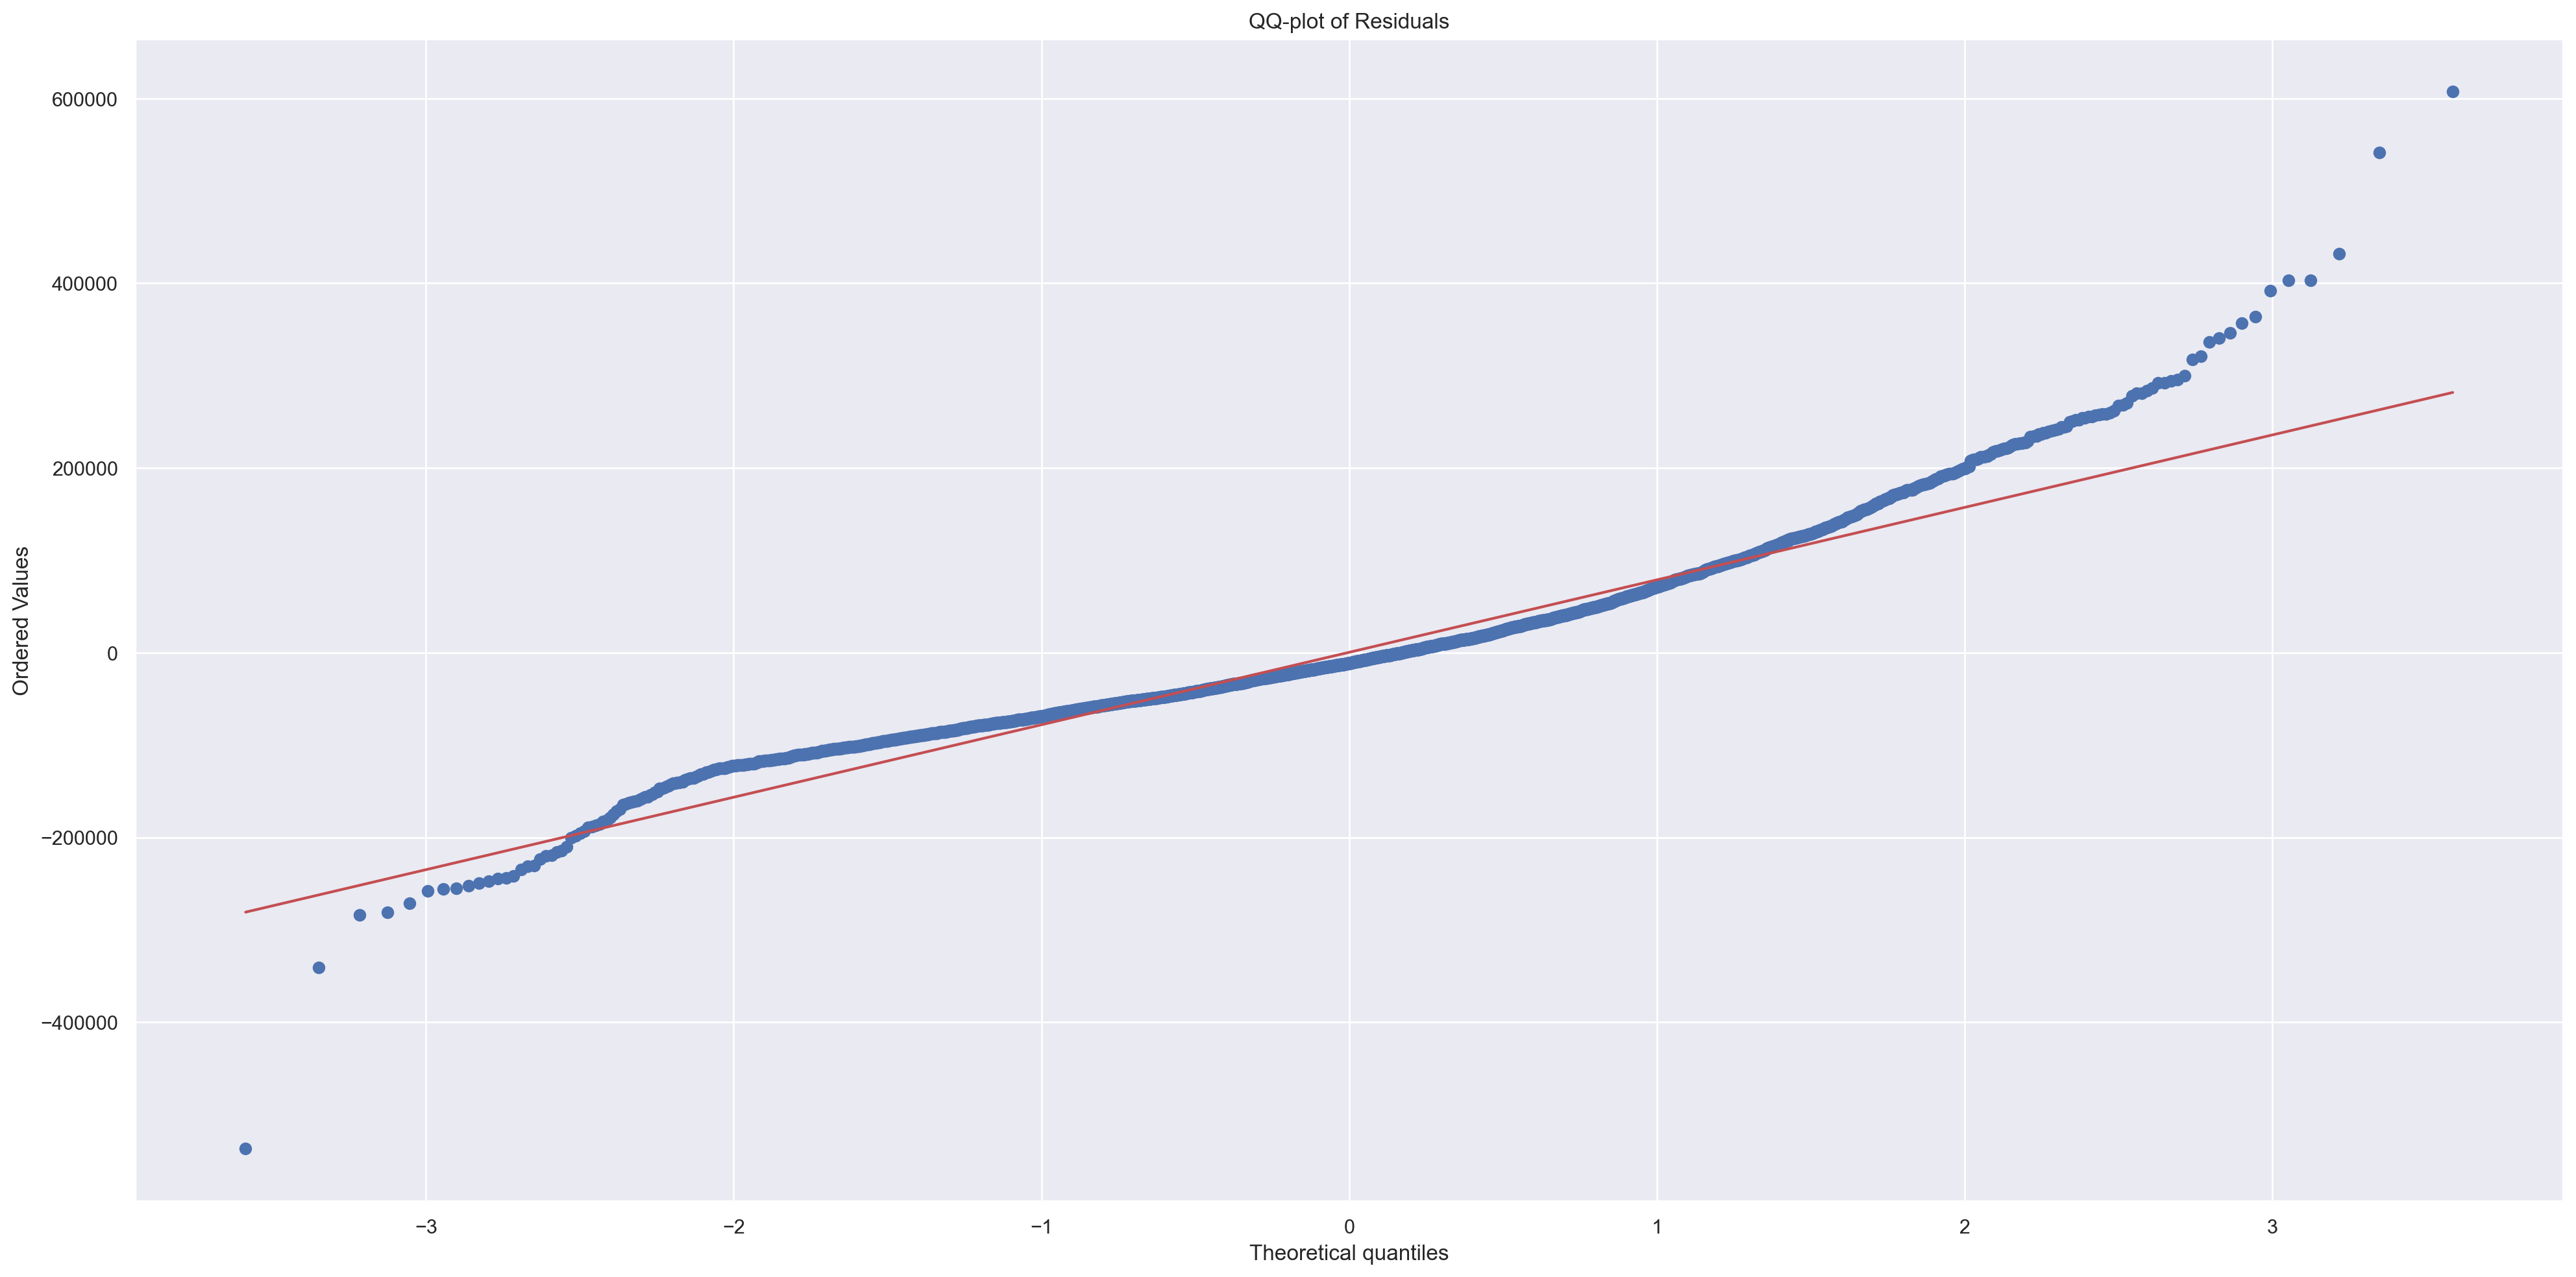

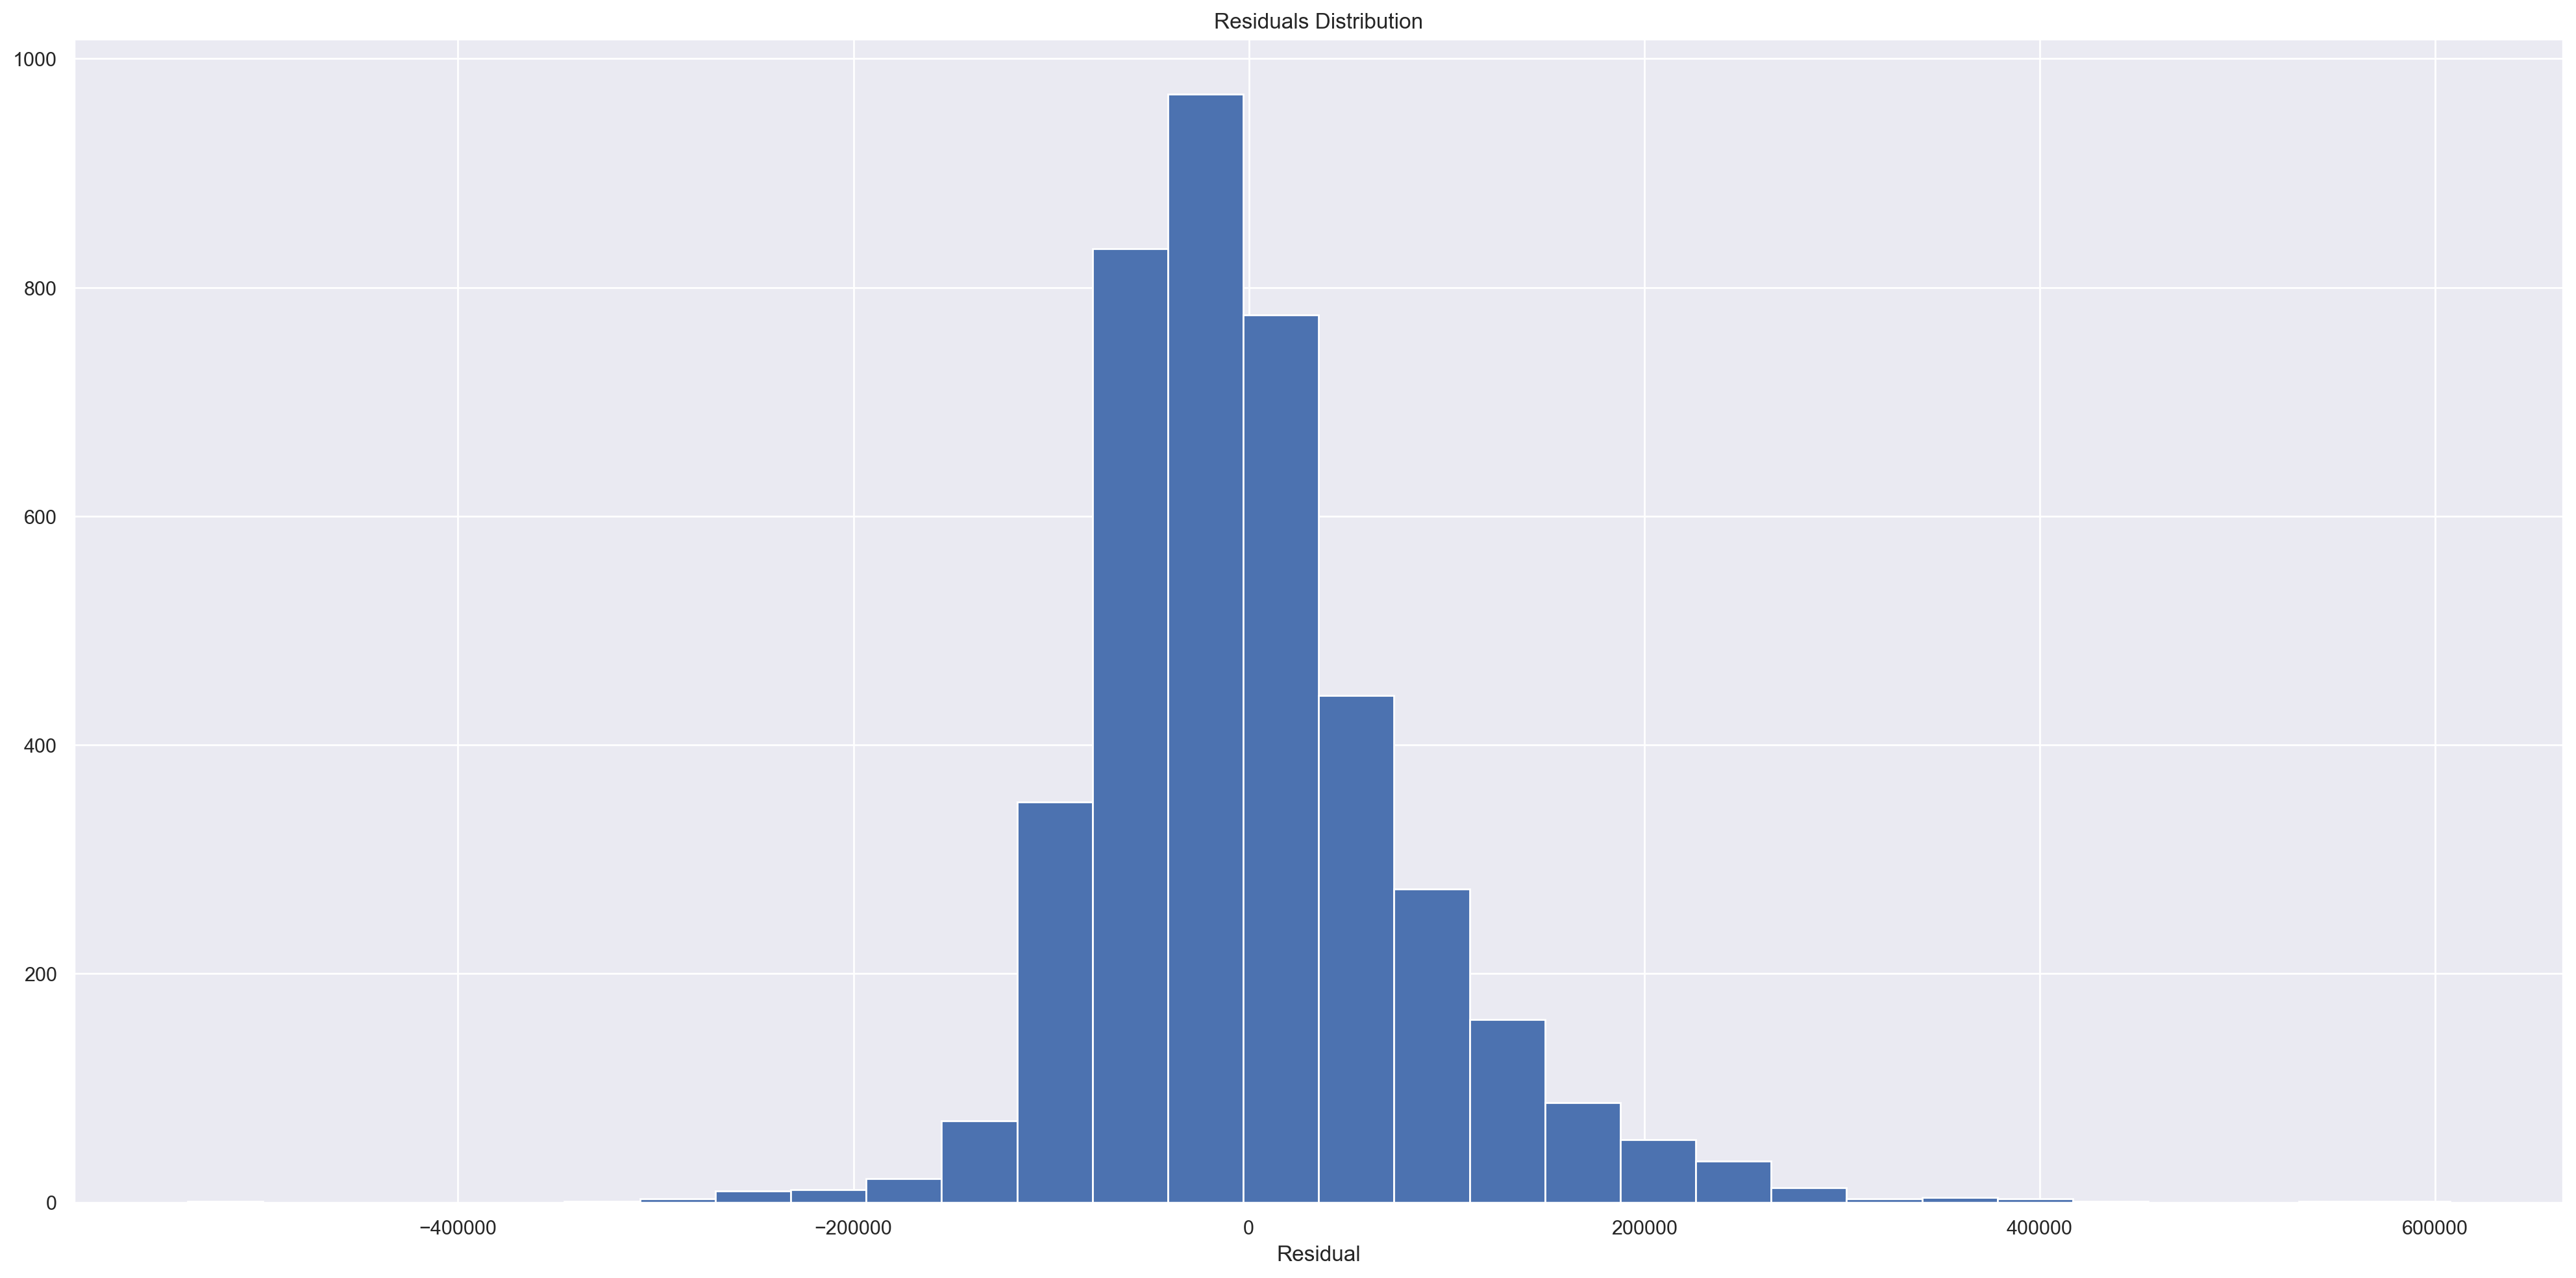

In [25]:
residuals = y_test_1d - y_pred_1d

# Residuals vs Predicted
plt.figure()
plt.scatter(ypred, residuals, alpha=0.5, s=12)
plt.axhline(0, ls="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
save_fig("residuals_vs_predicted")

# QQ-plot (against normal)
import scipy.stats as stats
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-plot of Residuals")
save_fig("qqplot_residuals")

# Distribution of residuals
plt.figure()
plt.hist(residuals, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
save_fig("residuals_hist")

,feature,coef
2,total_bedrooms,724334.871699
1,total_rooms,-516722.794204
4,median_income,404122.557074
3,households,-180681.317506
8,ocean_proximity_ISLAND,128893.345503
5,bedroom_ratio,-79476.494421
7,ocean_proximity_INLAND,-69960.877729
0,housing_median_age,65522.801053
6,ocean_proximity_<1H OCEAN,-9487.382533
10,ocean_proximity_NEAR OCEAN,8689.964997


Saved figure -> reports\figures\top_coefficients.png


<function matplotlib.pyplot.show(close=None, block=None)>

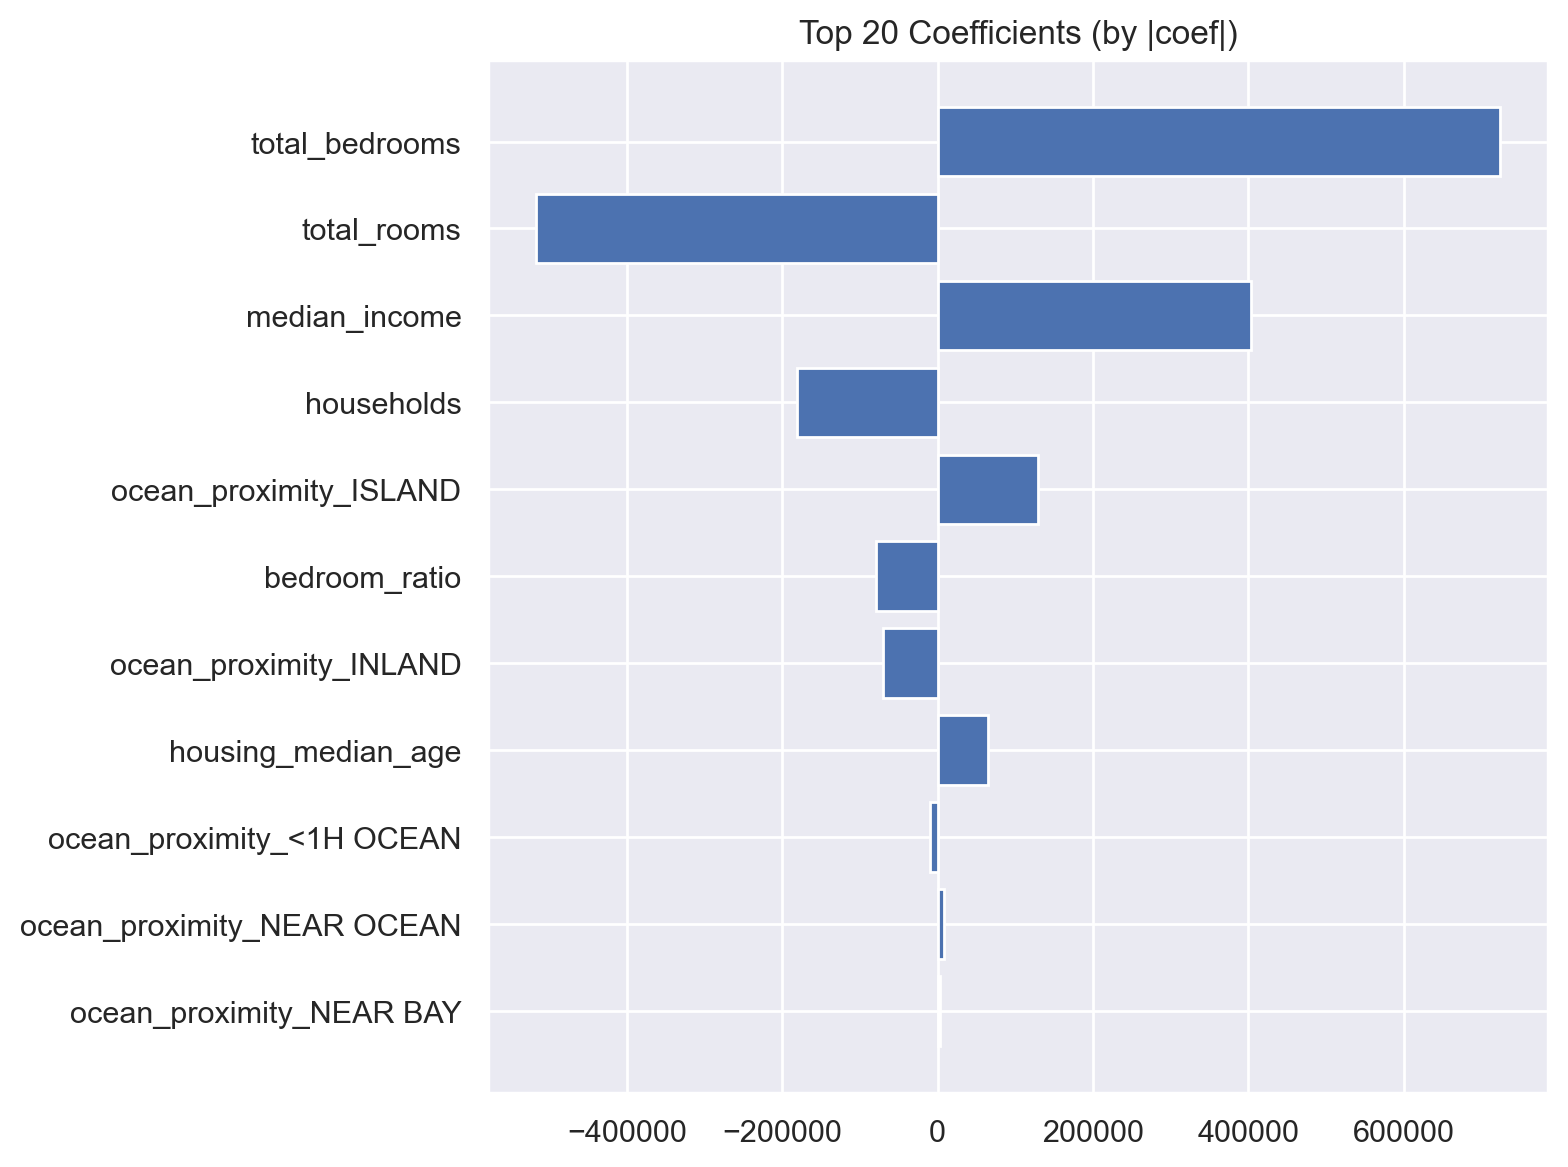

In [26]:
def get_feature_names(ct: ColumnTransformer):
    names = []
    for name, trans, cols in ct.transformers_:
        if name == "remainder": continue
        if hasattr(trans, "get_feature_names_out"):
            try: names += list(trans.get_feature_names_out(cols))
            except: names += list(cols)
        else:
            names += list(cols)
    return names

feature_names = get_feature_names(best.named_steps["prep"])
coefs = getattr(best.named_steps["model"], "coef_", None)
if coefs is not None:
    coef_df = pd.DataFrame({"feature": feature_names, "coef": np.ravel(coefs)})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    top = coef_df.sort_values("abs_coef", ascending=False).head(20)
    display(top[["feature","coef"]])

    plt.figure(figsize=(8,6))
    plt.barh(top["feature"][::-1], top["coef"][::-1])
    plt.title("Top 20 Coefficients (by |coef|)")
    plt.tight_layout()
    save_fig("top_coefficients")

plt.show

## 6. Conclusions & Next Steps

Based on the previous analysis, we can highlight the following findings:
- The most influential features were *total_bedrooms*, *total_rooms* and *median_income*. . This aligns with expectations: higher income and more bedrooms are associated with higher housing values. Interestingly, *total_rooms* showed a negative relationship, which warrants further investigation.
- Most residuals fall within approximately ±80,000. Given an average house price of ~200k, the model captures part of the variance but leaves substantial error, indicating limited predictive power.
- The residuals–predicted plot reveals a downward slope: the model tends to underestimate lower-priced houses and overestimate higher-priced ones. This systematic bias suggests non-linearity in the data, which is also supported by the QQ-plot’s deviation from the diagonal at the tails.

**Next steps**
To better capture the variance in housing prices, more flexible models should be considered such as polynomial regression, Random Forests, or Gradient Boosting methods. Nonetheless, this exercise demonstrates that even simple linear models, when carefully preprocessed and analyzed, can yield valuable insights into feature importance and data behavior.